In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from keras import models, layers, optimizers
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import SGD

In [3]:
from os import listdir, makedirs
from os.path import join, exists, expanduser

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
    
# !cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
# !cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
# !cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

print("Available Pretrained Models:")
# !ls ~/.keras/models


Available Pretrained Models:


In [4]:
monkey_species = os.listdir('10MonkeySpecies/training')
print("Number of Categories:", len(monkey_species))
print("Categories: ", monkey_species)

Number of Categories: 10
Categories:  ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [5]:
# dimensions of our images.
img_width, img_height = 224, 224 # we set the img_width and img_height according to the pretrained models we are
# going to use. The input size for ResNet-50 is 224 by 224 by 3.

train_data_dir = '10MonkeySpecies/training'
validation_data_dir = '10MonkeySpecies/validation'
batch_size = 4

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [7]:
nb_train_samples = len(train_generator.classes)
nb_validation_samples = len(validation_generator.classes)
print(nb_train_samples,nb_validation_samples)

1098 272


In [8]:
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [9]:
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])
testing_data = pd.DataFrame(validation_generator.classes, columns=['classes'])

In [10]:
def create_stack_bar_data(col, df):
    aggregated = df[col].value_counts().sort_index()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values

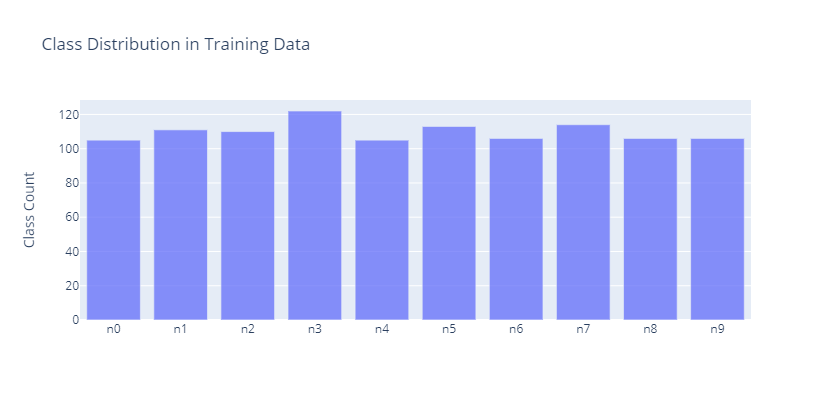

In [11]:
x1, y1 = create_stack_bar_data('classes', training_data)
x1 = list(train_generator.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1200, title='Class Distribution in Training Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count'))
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

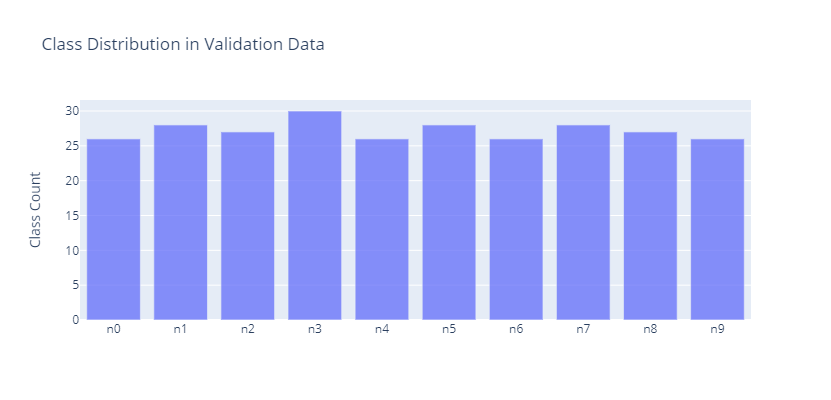

In [12]:
x1, y1 = create_stack_bar_data('classes', testing_data)
x1 = list(validation_generator.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1100, title='Class Distribution in Validation Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count'))
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

<h1> ANN MODEL </h1>

In [14]:
#import inception with pre-trained weights. do not include fully #connected layers
Xception_base = Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = Xception_base.output
x = layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = layers.Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = layers.Dense(int(len(train_generator.class_indices.keys())), activation='softmax')(x)
# create the full network so we can train on it
Xception_transfer = models.Model(inputs=Xception_base.input, outputs=predictions)

In [15]:
Xception_transfer.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])


In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16606307526277515959
xla_global_id: -1
]


In [29]:
import tensorflow as tf
# MODEL TRAINING ETA FOR 1 EPOCH 15 MINS
history = Xception_transfer.fit(
train_generator,
epochs=3, shuffle = True, verbose = 1, validation_data = validation_generator)

Epoch 1/3
275/275 [==============================] - 947s 3s/step - loss: 0.1602 - accuracy: 0.9599 - val_loss: 0.0347 - val_accuracy: 0.9963
Epoch 2/3
275/275 [==============================] - 1019s 4s/step - loss: 0.1539 - accuracy: 0.9499 - val_loss: 0.0340 - val_accuracy: 0.9963
Epoch 3/3
275/275 [==============================] - 997s 4s/step - loss: 0.1287 - accuracy: 0.9672 - val_loss: 0.0331 - val_accuracy: 0.9963


In [30]:
import os.path
Xception_transfer.save_weights('10MonkeySpecies/monkey.h5')

In [31]:
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'history5.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [32]:
# LOAD PRE TRAINED MODEL
Xception_transfer.load_weights('10MonkeySpecies/monkey.h5')

In [33]:
history = pd.read_csv('historyALL.csv')

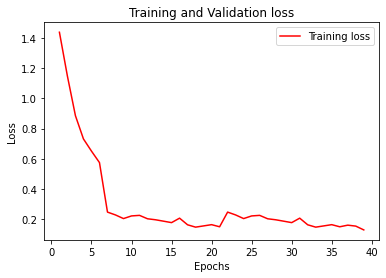

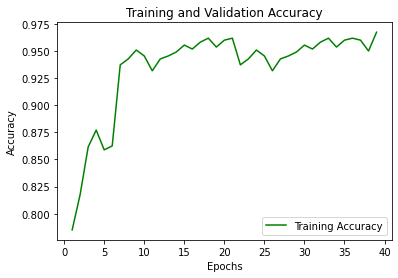

In [37]:
loss_train = history['loss']
epochs = range(1,40)
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history['accuracy']
epochs = range(1,40)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

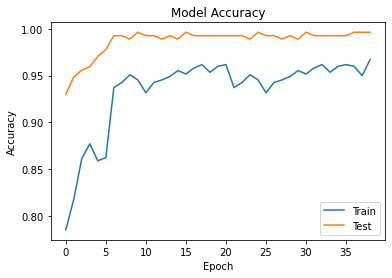

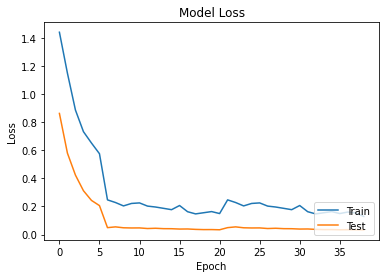

In [38]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()